#Question 1: Simplified Decision Tree


Methodoloy followed for implementation:

1. Main class node which contains the feature and threshold, both child nodes, prediction, leaf node determination, etc.
2. Function for entropy calculation
3. Function to calculate information gain ratio
4. Recursive function to build the decision tree.
5. Prediction function that traverses the decision tree to classify new data points


In [2]:
import numpy as np
from collections import Counter

class DecisionTreeNode:
    def __init__(self, feat_num=None, threshold=None, left=None, right=None, pred_class=None, prob_class1=None):
        self.left, self.right = left, right
        self.pred_class, self.prob_class1 = pred_class, prob_class1
        self.feat_num = feat_num
        self.threshold = threshold

def find_best_split(X, y):
    best_split = None
    best_gain = -1

    for j in range(X.shape[1]):
        unique_val = np.unique(X[:, j])
        for c in unique_val:
            l_index = X[:, j] >= c
            r_index = X[:, j] < c
            splits = [{'subset': y[l_index]}, {'subset': y[r_index]}]

            gain_ratio = igratio(y, splits)
            if gain_ratio > best_gain:
                best_gain = gain_ratio
                best_split = {'feat_num': j, 'threshold': c, 'splits': splits}

    return best_split

def entropy(y):
    if (len(y) == 0):
        return 0
    counts = np.bincount(y)
    prob = counts / len(y)
    return -np.sum([p * np.log2(p) for p in prob if p > 0])

def igratio(y, splits):
    total_entropy = entropy(y)
    weighted_entropy = split_info = 0

    for i in splits:
        subset = i['subset']
        split_weight = len(subset) / len(y)
        weighted_entropy += split_weight * entropy(subset)
        if split_weight > 0:
          split_info -= split_weight * np.log2(split_weight)
        else:
          split_info -=0

    gain = total_entropy - weighted_entropy
    if split_info == 0:
        return 0
    return gain / split_info

def build_dtree(X, y):
    if len(np.unique(y)) == 1:
        return DecisionTreeNode(pred_class=y[0], prob_class1=1 if y[0] == 1 else 0)

    if len(y) == 0:
        return DecisionTreeNode(pred_class=1)
    best_split = find_best_split(X, y)

    if best_split is None or best_split['splits'][0]['subset'].size == 0 or best_split['splits'][1]['subset'].size == 0:
        return DecisionTreeNode(pred_class=1 if np.sum(y) >= len(y) / 2 else 0)

    left_node = build_dtree(X[best_split['splits'][0]['subset']], best_split['splits'][0]['subset'])
    right_node = build_dtree(X[best_split['splits'][1]['subset']], best_split['splits'][1]['subset'])

    return DecisionTreeNode(feat_num=best_split['feat_num'], threshold=best_split['threshold'], left=left_node, right=right_node)

def predict_tree(node, x):
    if node.pred_class is not None:
        return node.pred_class

    if x[node.feat_num] >= node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)

#Testing the code:

x = np.array([[1, 1], [0, 1], [2, 6], [0, 6]])
y = np.array([0, 1, 1, 0])
x_test = np.array([[1, 3], [0, 0], [0, 6]])

root_node = build_dtree(x, y)
print("y_test:", [predict_tree(root_node, i) for i in x_test])

y_test: [0, 1, 1]


#2.2 Our algorithm is greedy

Handcraft a small training set where both classes are present but the
algorithm refuses to split; instead it makes the root a leaf and stop; Importantly, if we were to manually
force a split, the algorithm will happily continue splitting the data set further and produce a deeper tree with
zero training error. You should (1) plot your training set, (2) explain why. Hint: you don’t need more than a
handful of items.

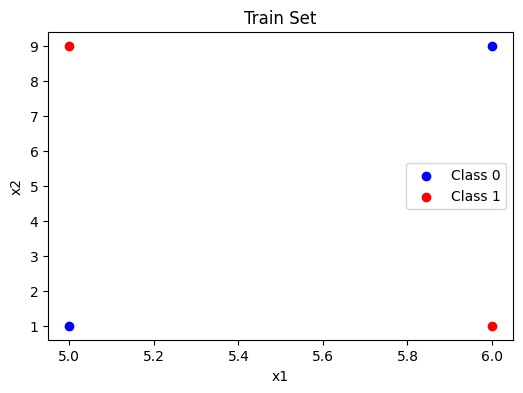

'decision_tree_visualization.pdf'

In [3]:
import graphviz
import matplotlib.pyplot as plt
x = np.array([[5, 1], [5, 9], [6, 9], [6, 1]])
y = np.array([0, 1, 0, 1])

c0 = x[y == 0]
c1 = x[y == 1]

plt.figure(figsize=(6, 4))
plt.scatter(c0[:, 0], c0[:, 1], c='blue', label='Class 0')
plt.scatter(c1[:, 0], c1[:, 1], c='red', label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Train Set')
plt.show()

root_node = build_dtree(x, y)

def visualize_tree(node, feat_names, class_names, temp=None):
    if temp is None:
        temp = graphviz.Digraph(comment='Decision Tree')

    if node.pred_class is not None:
        class_label = class_names[node.pred_class]
        temp.node(str(id(node)), label=f"Class: {class_label}")
    else:
        name = feat_names[node.feat_num]
        temp.node(str(id(node)), label=f"{name} >= {node.threshold:.2f}?", shape="box")

        if node.left:
            temp.edge(str(id(node)), str(id(node.left)), label="Yes")
            visualize_tree(node.left, feat_names, class_names, temp)

        if node.right:
            temp.edge(str(id(node)), str(id(node.right)), label="No")
            visualize_tree(node.right, feat_names, class_names, temp)

    return temp

feat_names = ["Feature 1", "Feature 2"]
class_names = ["Class 0", "Class 1"]

visualize_tree(root_node, feat_names, class_names).render("decision_tree_visualization", view=True)

#Question 2.3: Information gain ratio exercise


Use the training set Druns.txt. For the root node, list all candidate
cuts and their information gain ratio. If the entropy of the candidate split is zero, please list its mutual
information (i.e. information gain). Hint: to get log2
(x) when your programming language may be using a
different base, use log(x)/log(2). Also, please follow the split rule in the first section.

In [4]:
import numpy as np
import math
from collections import Counter
data = np.loadtxt("Druns.txt")
x, y = data[:, :-1], data[:, -1]

def entropy(y):
    if len(y) == 0:
        return 0
    counts = np.bincount(y.astype(int))
    probabilities = counts / len(y)
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy

H = entropy(y)

cuts = []
ratios = []

for i in range(x.shape[1]):
    feat_val = x[:, i]
    unique_values = np.unique(feat_val)
    for j in unique_values:
        left_indices = x[:, i] >= j
        right_indices = x[:, i] < j
        splits = [{'subset': y[left_indices]}, {'subset': y[right_indices]}]

        gain = H - sum(len(split['subset']) / len(y) * entropy(split['subset']) for split in splits)
        split_info = -sum(len(split['subset']) / len(y) * math.log2(len(split['subset']) / len(y)) for split in splits if len(split['subset']) > 0)

        if split_info == 0:
            mutual_information = gain
            ratios.append((i, j, mutual_information))
        else:
            gain_ratio = gain / split_info
            ratios.append((i, j, gain_ratio))

ratios.sort(key=lambda x: (x[2], x[1]), reverse=True)

for j, c, gain_ratio in ratios:
    print(f"Cut at feature {j},threshold {c}: \nInformation Gain Ratio = {gain_ratio:.4f}\n")


Cut at feature 1,threshold 8.0: 
Information Gain Ratio = 0.4302

Cut at feature 1,threshold 6.0: 
Information Gain Ratio = 0.2361

Cut at feature 1,threshold 5.0: 
Information Gain Ratio = 0.1112

Cut at feature 0,threshold 0.1: 
Information Gain Ratio = 0.1005

Cut at feature 1,threshold -1.0: 
Information Gain Ratio = 0.1005

Cut at feature 1,threshold 7.0: 
Information Gain Ratio = 0.0560

Cut at feature 1,threshold 0.0: 
Information Gain Ratio = 0.0560

Cut at feature 1,threshold 4.0: 
Information Gain Ratio = 0.0497

Cut at feature 1,threshold 3.0: 
Information Gain Ratio = 0.0164

Cut at feature 1,threshold 1.0: 
Information Gain Ratio = 0.0058

Cut at feature 1,threshold 2.0: 
Information Gain Ratio = 0.0011

Cut at feature 0,threshold 0.0: 
Information Gain Ratio = 0.0000

Cut at feature 1,threshold -2.0: 
Information Gain Ratio = 0.0000



#2.4 The king of interpretability

Decision tree is not the most accurate classifier in general. However,
it persists. This is largely due to its rumored interpretability: a data scientist can easily explain a tree to a
non-data scientist. Build a tree from D3leaves.txt. Then manually convert your tree to a set of logic rules.
Show the tree1
and the rules.

Rules:
1. If x1 >= 10.0:
   - Predict class 1
2. If x1 < 10.0 and x2 >= 2.0:
   - Predict class 1
3. If x1 < 10.0 and x2 < 2.0:
   - Predict class 0


In [5]:
import numpy as np

data = np.array([[10, 1, 1], [10, 2, 1], [10, 3, 1], [1, 1, 0], [1, 3, 1]])
#These values are exactly taken from as D3leaves
x, y = data[:, :-1], data[:, -1]

class DecisionTreeNode:
    def __init__(self, feat_num=None, threshold=None, left=None, right=None, pred_class=None):
        self.feat_num = feat_num
        self.threshold = threshold
        self.left, self.right = left, right
        self.pred_class = pred_class

def entropy(y):
    if len(y) == 0:
        return 0
    counts = np.bincount(y)
    probabilities = counts / len(y)
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy

def information_gain_ratio(y, splits):
    H = entropy(y)
    weighted_entropy = 0
    split_info = 0

    for i in splits:
        split_weight = len(i['subset']) / len(y)
        weighted_entropy += split_weight * entropy(i['subset'])
        split_info -= split_weight * np.log2(split_weight) if split_weight > 0 else 0

    gain = H - weighted_entropy
    if split_info == 0:
        return 0
    gain_ratio = gain / split_info
    return gain_ratio

def find_best_split(x, y):
    best_split = None
    best_gain_ratio = -1

    for i in range(x.shape[1]):
        unique_values = np.unique(x[:, i])
        for c in unique_values:
            l_index = x[:, i] >= c
            r_index = x[:, i] < c
            splits = [{'subset': y[l_index]}, {'subset': y[r_index]}]
            if information_gain_ratio(y, splits) > best_gain_ratio:
                best_gain_ratio = information_gain_ratio(y, splits)
                best_split = {'feat_num': i, 'threshold': c, 'splits': splits}

    return best_split

def build_dtree(x, y):
    if len(np.unique(y)) == 1:
        return DecisionTreeNode(pred_class=y[0])
    if len(y) == 0:
        return DecisionTreeNode(pred_class=1 if np.sum(y) >= len(y) / 2 else 0)
    best_split = find_best_split(x, y)
    if best_split is None or best_split['splits'][0]['subset'].size == 0 or best_split['splits'][1]['subset'].size == 0:
        return DecisionTreeNode(pred_class=1 if np.sum(y) >= len(y) / 2 else 0)

    left_node = build_dtree(x[best_split['splits'][0]['subset']], best_split['splits'][0]['subset'])
    right_node = build_dtree(x[best_split['splits'][1]['subset']], best_split['splits'][1]['subset'])
    return DecisionTreeNode(feat_num=best_split['feat_num'], threshold=best_split['threshold'], left=left_node, right=right_node)

root_node = build_dtree(x, y)


In [6]:
feature_names = ["x1", "x2"]
class_names = ["Class 0", "Class 1"]

temp = visualize_tree(root_node, feature_names, class_names)
temp.render("2point4", view=True)

'2point4.pdf'

# 2.5 Or is it?

For this question only, make sure you DO NOT VISUALIZE the data sets or plot your tree's decision boundary in the 2D x space.  If your code does that, turn it off before proceeding.  This is because you want to see your own reaction when trying to interpret a tree.  You will get points no matter what your interpretation is.
And we will ask you to visualize them in the next question anyway.

• Build a decision tree on D1.txt. Show it to us in any format (e.g. could be a standard binary tree with
nodes and arrows, and denote the rule at each leaf node; or as simple as plaintext output where each
line represents a node with appropriate line number pointers to child nodes; whatever is convenient
for you). Again, do not visualize the data set or the tree in the x input space. In real tasks you will not
be able to visualize the whole high dimensional input space anyway, so we don’t want you to “cheat”
here.

• Look at your tree in the above format (remember, you should not visualize the 2D dataset or your
tree’s decision boundary) and try to interpret the decision boundary in human understandable English.

• Build a decision tree on D2.txt. Show it to us.

• Try to interpret your D2 decision tree. Is it easy or possible to do so without visualization?

In [7]:
import numpy as np
data = np.loadtxt('D1.txt')
x, y = data[:, :-1], data[:, -1].astype(int)
root_node = build_dtree(x, y)
feature_names = ["x1", "x2"]
class_names = ["Class 0", "Class 1"]

temp = visualize_tree(root_node, feature_names, class_names)
temp.render("2point5a", view=True)

'2point5a.pdf'

In [8]:
import numpy as np
data = np.loadtxt('D2.txt')
x, y = data[:, :-1], data[:, -1].astype(int)
root_node = build_dtree(x, y)
feature_names = ["x1", "x2"]
class_names = ["Class 0", "Class 1"]

temp = visualize_tree(root_node, feature_names, class_names)
temp.render("2point5b", view=True)

'2point5b.pdf'

# 2.6 Hypothesis space

 For D1.txt and D2.txt, do the following separately:

• Produce a scatter plot of the data set.

• Visualize your decision tree’s decision boundary (or decision region, or some other ways to clearly
visualize how your decision tree will make decisions in the feature space).
Then discuss why the size of your decision trees on D1 and D2 differ. Relate this to the hypothesis space of
our decision tree algorithm.

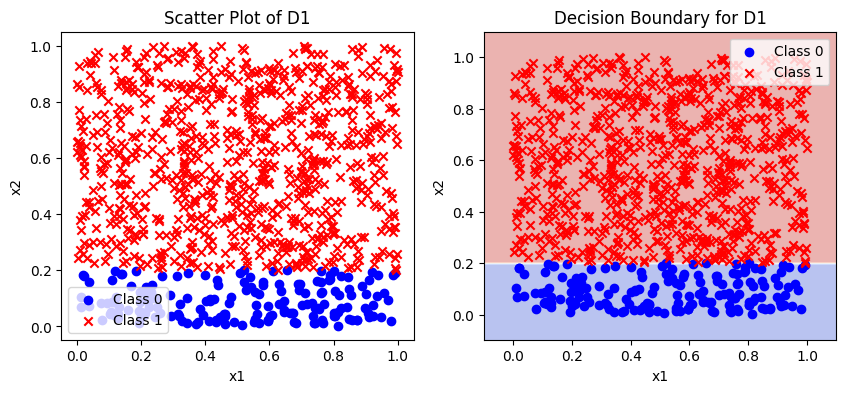

In [9]:
import matplotlib.pyplot as plt
import numpy as np

data_d1 = np.loadtxt('D1.txt')
x_d1, y_d1 = data_d1[:, :-1], data_d1[:, -1].astype(int)

data_d2 = np.loadtxt('D2.txt')
X_d2, y_d2 = data_d2[:, :-1], data_d2[:, -1].astype(int)

d1root = build_dtree(x_d1, y_d1)
d2root = build_dtree(X_d2, y_d2)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(x_d1[y_d1 == 0][:, 0], x_d1[y_d1 == 0][:, 1], label='Class 0', marker='o', color='blue')
plt.scatter(x_d1[y_d1 == 1][:, 0], x_d1[y_d1 == 1][:, 1], label='Class 1', marker='x', color='red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter Plot of D1')
plt.legend()

plt.subplot(1, 2, 2)
x1_min, x1_max = x_d1[:, 0].min() - 0.1, x_d1[:, 0].max() + 0.1
x2_min, x2_max = x_d1[:, 1].min() - 0.1, x_d1[:, 1].max() + 0.1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
Z_d1 = np.array([predict_tree(d1root, [x1, x2]) for x1, x2 in np.c_[xx1.ravel(), xx2.ravel()]])
Z_d1 = Z_d1.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z_d1, alpha=0.4, cmap='coolwarm')
plt.scatter(x_d1[y_d1 == 0][:, 0], x_d1[y_d1 == 0][:, 1], label='Class 0', marker='o', color='blue')
plt.scatter(x_d1[y_d1 == 1][:, 0], x_d1[y_d1 == 1][:, 1], label='Class 1', marker='x', color='red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Boundary for D1')
plt.legend()
plt.show()


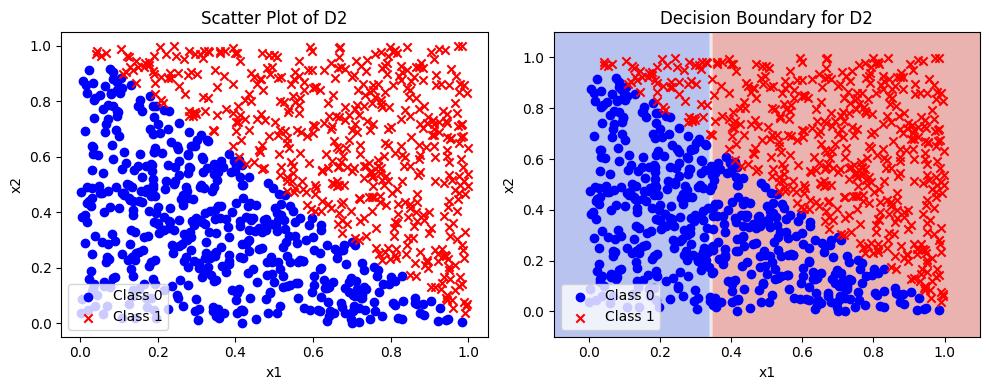

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_d2[y_d2 == 0][:, 0], X_d2[y_d2 == 0][:, 1], label='Class 0', marker='o', color='blue')
plt.scatter(X_d2[y_d2 == 1][:, 0], X_d2[y_d2 == 1][:, 1], label='Class 1', marker='x', color='red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter Plot of D2')
plt.legend()

plt.subplot(1, 2, 2)
x1_min, x1_max = X_d2[:, 0].min() - 0.1, X_d2[:, 0].max() + 0.1
x2_min, x2_max = X_d2[:, 1].min() - 0.1, X_d2[:, 1].max() + 0.1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
Z_d2 = np.array([predict_tree(d2root, [x1, x2]) for x1, x2 in np.c_[xx1.ravel(), xx2.ravel()]])
Z_d2 = Z_d2.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z_d2, alpha=0.4, cmap='coolwarm')
plt.scatter(X_d2[y_d2 == 0][:, 0], X_d2[y_d2 == 0][:, 1], label='Class 0', marker='o', color='blue')
plt.scatter(X_d2[y_d2 == 1][:, 0], X_d2[y_d2 == 1][:, 1], label='Class 1', marker='x', color='red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Boundary for D2')
plt.legend()

plt.tight_layout()
plt.show()


# 2.7 Learning curve

We provide a data set Dbig.txt with 10000 labeled items. Caution: Dbig.txt is
sorted.

• You will randomly split Dbig.txt into a candidate training set of 8192 items and a test set (the rest).
Do this by generating a random permutation, and split at 8192.

• Generate a sequence of five nested training sets D32 ⊂ D128 ⊂ D512 ⊂ D2048 ⊂ D8192 from the
candidate training set. The subscript n in Dn denotes training set size. The easiest way is to take
the first n items from the (same) permutation above. This sequence simulates the real world situation
where you obtain more and more training data.

• For each Dn above, train a decision tree. Measure its test set error errn. Show three things in your
answer: (1) List n, number of nodes in that tree, errn. (2) Plot n vs. errn. This is known as a learning
curve (a single plot). (3) Visualize your decision trees’ decision boundary (five plots).

In [11]:
import random
with open('Dbig.txt', 'r') as file:
    data = file.readlines()
random.seed(490)
perm = random.sample(range(len(data)), len(data))
x = [data[i] for i in perm[:8192]]
y = [data[i] for i in perm[8192:]]
train_sizes = [32, 128, 512, 2048, 8192]
nested_training_sets = {}

for i in train_sizes:
    nested_training_sets[f'D{i}'] = [x[j] for j in range(i)]

In [12]:
nested_training_sets.keys()

dict_keys(['D32', 'D128', 'D512', 'D2048', 'D8192'])

In [19]:
import random
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def count_nodes(node):
    if node is None:
        return 0
    return 1 + count_nodes(node.left) + count_nodes(node.right)

n_values = []
num_nodes_values = []
test_errors = []

for i in train_sizes:
    x_train = np.array([[float(j) for j in item.split()[:-1]] for item in nested_training_sets[f'D{i}']])
    y_train = np.array([int(item.split()[-1]) for item in nested_training_sets[f'D{i}']])
    root_node = build_dtree(x_train, y_train)

    x_test = np.array([[float(j) for j in item.split()[:-1]] for item in y])
    y_test = np.array([int(item.split()[-1]) for item in y])
    predictions = [predict_tree(root_node, j) for j in x_test]

    test_error = 1 - accuracy_score(y_test, predictions)

    n_values.append(i)
    num_nodes_values.append(count_nodes(root_node))
    test_errors.append(test_error)

print("n\tNum of Nodes\terr_n")
for n, num_nodes, test_error in zip(n_values, num_nodes_values, test_errors):
    print(f"{n}\t{num_nodes}\t\t{test_error}")

plt.plot(n_values, test_errors, marker='o', linestyle='-')
plt.title('Learning Curve')
plt.xlabel('n')
plt.ylabel('err_n')
plt.grid(True)
plt.show()


n	Num of Nodes	err_n


In [22]:
def visualize_decision_boundary(x, y, root, dataset):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], label='Class 0', marker='o', color='blue')
    plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], label='Class 1', marker='x', color='red')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Scatter Plot of {dataset}')
    plt.legend()

    plt.subplot(1, 2, 2)
    x1_min, x1_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    x2_min, x2_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    Z = np.array([predict_tree(root, [x1, x2]) for x1, x2 in np.c_[xx1.ravel(), xx2.ravel()]])
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap='coolwarm')
    plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], label='Class 0', marker='o', color='blue')
    plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], label='Class 1', marker='x', color='red')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Decision Boundary for {dataset}')
    plt.legend()

    plt.tight_layout()
    plt.show()


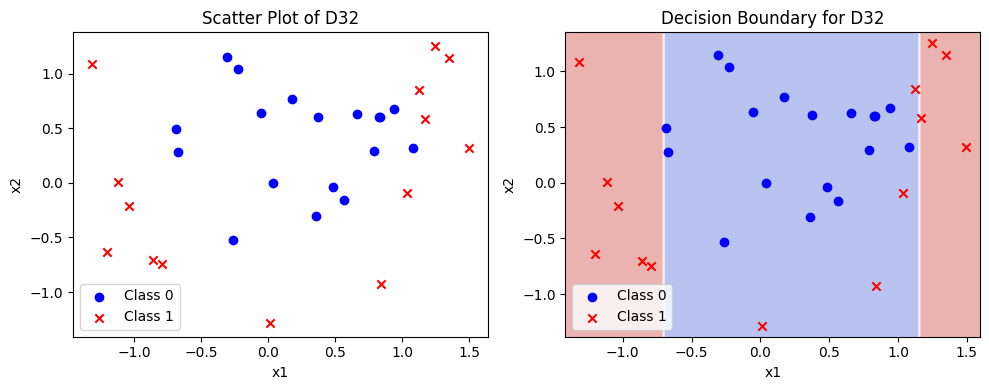

In [23]:
d32 = np.loadtxt(nested_training_sets['D32'])
x_d32, y_d32= d32[:, :-1], d32[:, -1].astype(int)
visualize_decision_boundary(x_d32, y_d32, build_dtree(x_d32, y_d32), 'D32')

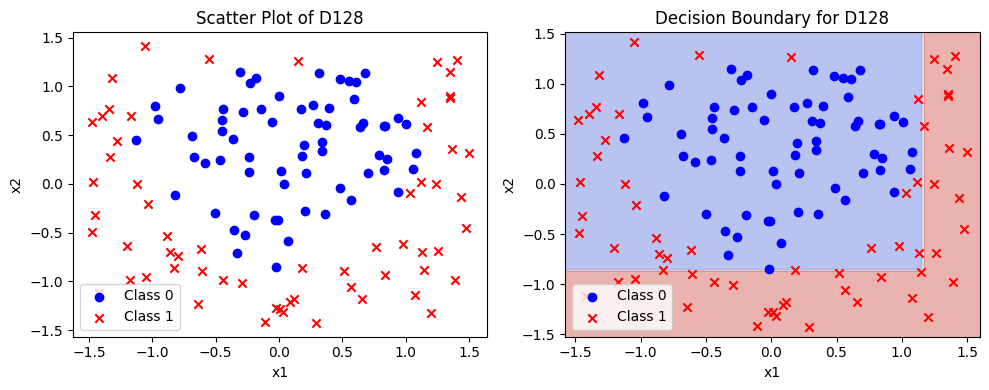

In [24]:
d128 = np.loadtxt(nested_training_sets['D128'])
x_d128, y_d128= d128[:, :-1], d128[:, -1].astype(int)
visualize_decision_boundary(x_d128, y_d128, build_dtree(x_d128, y_d128), 'D128')

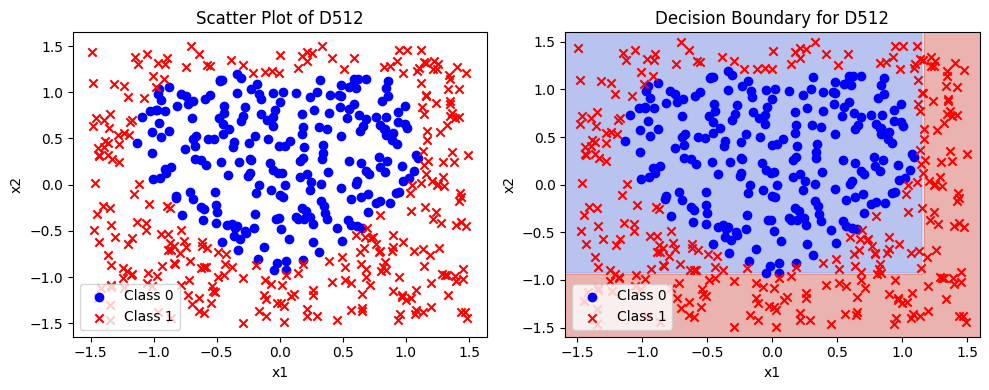

In [25]:
d512 = np.loadtxt(nested_training_sets['D512'])
x_d512, y_d512= d512[:, :-1], d512[:, -1].astype(int)
visualize_decision_boundary(x_d512, y_d512, build_dtree(x_d512, y_d512), 'D512')

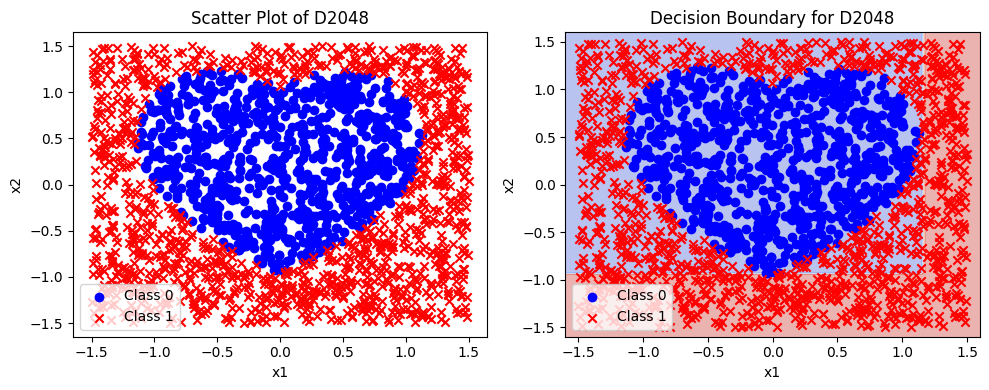

In [26]:
d2048 = np.loadtxt(nested_training_sets['D2048'])
x_d2048, y_d2048= d2048[:, :-1], d2048[:, -1].astype(int)
visualize_decision_boundary(x_d2048, y_d2048, build_dtree(x_d2048, y_d2048), 'D2048')

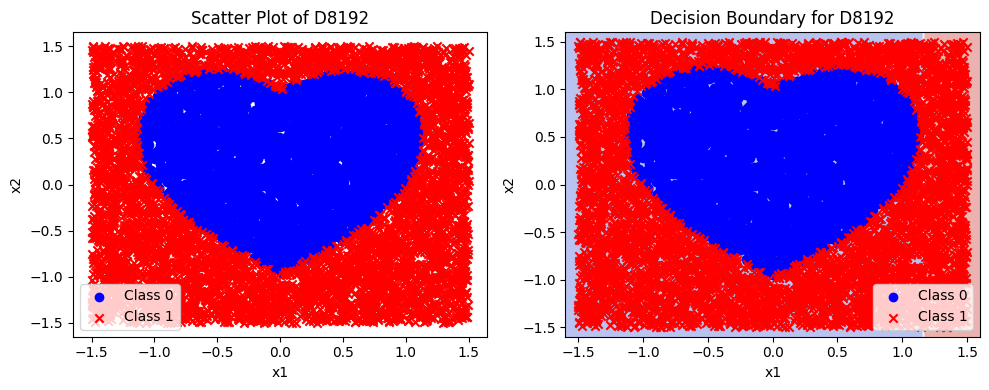

In [27]:
d8192 = np.loadtxt(nested_training_sets['D8192'])
x_d8192, y_d8192= d8192[:, :-1], d8192[:, -1].astype(int)
visualize_decision_boundary(x_d8192, y_d8192, build_dtree(x_d8192, y_d8192), 'D8192')